# Accessing release 2.0 of the Chandra Source Catalog with PyVO

The [PyVo](https://pyvo.readthedocs.io/) package allows users to query Virtual Observatory services from Python. In this notebook we show how you can use it to query [release 2.0 of the Chandra Source Catalog](https://cxc.cfa.harvard.edu/csc2/) using the [VO interfaces](https://cxc.harvard.edu/csc/download.html#vo).

This notebook assumes you have installed CIAO 4.13 using conda, but you should also be able to do this with a CIAO installed using the `ciao-install` script, or any other Python environment as we are just going to use [Astropy](https://www.astropy.org/) along with `pyvo`. The `pyyaml` poackage is needed to support writing out the file (it avoids a warning message you would get).

Packages to install:

 - `pip install astropy pyvo pyyaml matplotlib`

In [3]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib

import astropy
import pyvo as vo

%matplotlib inline

In [5]:
help(np)

Help on package numpy:

NAME
    numpy

DESCRIPTION
    NumPy
    =====
    
    Provides
      1. An array object of arbitrary homogeneous items
      2. Fast mathematical operations over arrays
      3. Linear Algebra, Fourier Transforms, Random Number Generation
    
    How to use the documentation
    ----------------------------
    Documentation is available in two forms: docstrings provided
    with the code, and a loose standing reference guide, available from
    `the NumPy homepage <https://www.scipy.org>`_.
    
    We recommend exploring the docstrings using
    `IPython <https://ipython.org>`_, an advanced Python shell with
    TAB-completion and introspection capabilities.  See below for further
    instructions.
    
    The docstring examples assume that `numpy` has been imported as `np`::
    
      >>> import numpy as np
    
    Code snippets are indicated by three greater-than signs::
    
      >>> x = 42
      >>> x = x + 1
    
    Use the built-in ``help`` func

Let's just check the versions (it is expected that the results should not depend on these versions):

In [44]:
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyVO        - {vo.__version__}")

Versions:
  NumPy       - 1.22.4
  Matplotlib  - 3.5.2
  AstroPy     - 5.1
  PyVO        - 1.3


## Aim

This document shows how to use a cone search - that is, find results around a given location - and then run a general "database query", which can be done over the whole sky.

The Virtual Observatory cone-search interface is "simple", in that you give it a location, radius, and an optional "verbosity" parameter between 1 and 3, inclusive, that controls the number of columns that gets returned. The details can be found at the [CSC 2.0 cone search](http://cda.cfa.harvard.edu/cscvo/) page.

The Table Access Protocol, used for the "all-sky" query, allows much-more general queries, but you have to actually write them yourself. It is suggested that you use [CSCView](http://cda.harvard.edu/cscview/) to create a query, and then view the query - using the `View/Quety/Show Language` menu item - to see what query it has created: this is important for complex queries where you are trying to access data from multiple tables (e.g. observation-level fluxes mapped to a given master source), since there are many "hidden" traps in these queries which CSCView knows about.

### Cone Search

Let's start with a two arcminute radius around NGC 1333, for which we will use the name resolver from Astropy:

In [45]:
from astropy.coordinates import SkyCoord
from astropy import units as u

ngc1333 = SkyCoord.from_name('NGC 1333')
maxrad = 2.0 * u.arcmin

In [46]:
ngc1333

<SkyCoord (ICRS): (ra, dec) in deg
    (52.297, 31.31)>

I now need a Python object representing the 
[CSC2 Virtual Observatory Cone Search Service](http://cda.cfa.harvard.edu/cscvo/), which has a base URL of `http://cda.cfa.harvard.edu/csc2scs/coneSearch`:

In [47]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

To run the search we are going to use the `search` method, which (fortunately for this notebook) has a short help page so I can include it:

In [48]:
help(cone.search)

Help on method search in module pyvo.dal.scs:

search(pos, radius=1.0, verbosity=2, **keywords) method of pyvo.dal.scs.SCSService instance
    submit a simple Cone Search query that requests objects or observations
    whose positions fall within some distance from a search position.
    
    Parameters
    ----------
    pos : astropy.coordinates.SkyCoord
        a SkyCoord instance defining the position of the center of the
        circular search region.
        converted if it's a iterable containing scalars,
        assuming icrs degrees.
    radius : `~astropy.units.Quantity` or float
        a Quantity instance defining the radius of the circular search
        region, in degrees.
        converted if it is another unit.
    verbosity : int
       an integer value that indicates the volume of columns
       to return in the result table.  0 means the minimum
       set of columns, 3 means as many columns as are available.
    **keywords :
       additional case insensitive param

We can then run the query with the following (the arguments don't need to be named but it makes things a bit clearer to be explicit):

In [49]:
results = cone.search(pos=ngc1333, radius=maxrad)

Hopefully this completes without error, and returns 11 results (note that it depends on the location returned by the name search and so can change when the SIMBAD or NED results change):

In [50]:
len(results)

11

In [51]:
results

<Table length=11>
         name                 ra         ... var_inter_index_b var_inter_index_w
                             deg         ...                                    
        object             float64       ...       int32             int32      
--------------------- ------------------ ... ----------------- -----------------
2CXO J032903.3+311839 52.264053208173095 ...                 8                --
2CXO J032906.5+311933  52.27748479124614 ...                 0                --
2CXO J032908.3+312020  52.28463480776571 ...                 5                --
2CXO J032909.2+312013  52.28852472101971 ...                 0                --
2CXO J032911.3+311717 52.297138025389756 ...                 8                --
2CXO J032912.7+312007  52.30321625483373 ...                 5                --
2CXO J032912.9+311814 52.303936134512355 ...                 8                --
2CXO J032913.5+311743  52.30662998943154 ...                 6                --
2CXO J0329

The fact that the source names begin with '2CXO' means that we are indeed searching release 2.0 and not 1.1. Let's see what the default columns are (note that this search was run with the cone-search `verbosity` parameter set to 2, which http://cda.cfa.harvard.edu/cscvo/ tells us returns the following master-source columns: `m.name`, `m.ra`, `m.dec`, `m.err_ellipse_r0`, `m.conf_flag`, `m.sat_src_flag`, `m.significance`, `m.flux_aper_b`, `m.flux_aper_lolim_b`, `m.flux_aper_hilim_b`, `m.flux_aper_w`, `m.flux_aper_lolim_w`, `m.flux_aper_hilim_w`, `m.extent_flag`, `m.hard_hm`, `m.hard_hm_lolim`, `m.hard_hm_hilim`, `m.hard_ms`, `m.hard_ms_lolim`, `m.hard_ms_hilim`, `m.var_intra_index_b`, `m.var_inter_index_b`, `m.var_intra_index_w`, and `m.var_inter_index_w`.

The results can be converted to an AstroPy table - using `results.to_table()`, which we use below - but they can also be used directly:

In [52]:
results.fieldnames

('name',
 'ra',
 'dec',
 'err_ellipse_r0',
 'conf_flag',
 'extent_flag',
 'sat_src_flag',
 'flux_aper_b',
 'flux_aper_lolim_b',
 'flux_aper_hilim_b',
 'flux_aper_w',
 'flux_aper_lolim_w',
 'flux_aper_hilim_w',
 'significance',
 'hard_hm',
 'hard_hm_lolim',
 'hard_hm_hilim',
 'hard_ms',
 'hard_ms_lolim',
 'hard_ms_hilim',
 'var_intra_index_b',
 'var_intra_index_w',
 'var_inter_index_b',
 'var_inter_index_w')

In [53]:
results['name']

masked_array(data=['2CXO J032903.3+311839', '2CXO J032906.5+311933',
                   '2CXO J032908.3+312020', '2CXO J032909.2+312013',
                   '2CXO J032911.3+311717', '2CXO J032912.7+312007',
                   '2CXO J032912.9+311814', '2CXO J032913.5+311743',
                   '2CXO J032915.6+311851', '2CXO J032918.5+311925',
                   '2CXO J032920.4+311834'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object)

We can iterate through the sources:

In [54]:
for r in results:
    out = f"{r['name']} flux={r['flux_aper_b']:.3e}  "
    out += f"{r['flux_aper_lolim_b']:.3e} - {r['flux_aper_hilim_b']:.3e}"
    print(out)

2CXO J032903.3+311839 flux=0.000e+00  0.000e+00 - 2.780e-16
2CXO J032906.5+311933 flux=5.838e-15  4.613e-15 - 7.063e-15
2CXO J032908.3+312020 flux=nan  nan - nan
2CXO J032909.2+312013 flux=1.302e-15  6.820e-16 - 1.922e-15
2CXO J032911.3+311717 flux=5.124e-16  1.708e-16 - 8.398e-16
2CXO J032912.7+312007 flux=7.360e-16  4.279e-16 - 1.044e-15
2CXO J032912.9+311814 flux=8.559e-14  7.828e-14 - 9.244e-14
2CXO J032913.5+311743 flux=0.000e+00  0.000e+00 - 9.234e-16
2CXO J032915.6+311851 flux=1.300e-14  1.091e-14 - 1.496e-14
2CXO J032918.5+311925 flux=1.191e-14  9.853e-15 - 1.382e-14
2CXO J032920.4+311834 flux=2.206e-14  1.956e-14 - 2.441e-14


display them:

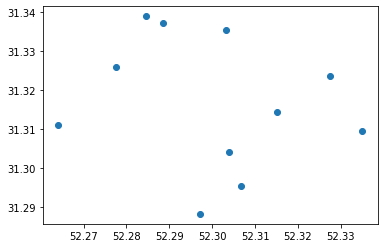

In [55]:
plt.plot(results['ra'], results['dec'], 'o');

or a look at how the flux is related to significance (note that in the Chandra Source Catalog, detection significance is not expected to correlate directly with flux, for a number of reasons, including that there is no guarantee that at the master source level the significance value refers to the same band as plotted and the significance involves the detection algorithm, rather than the calculation of flux.

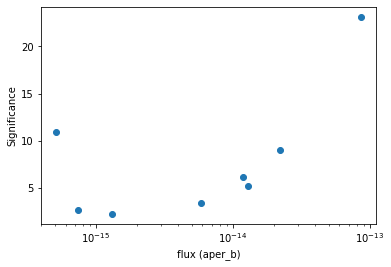

In [56]:
plt.plot(results['flux_aper_b'], results['significance'], 'o')
plt.xlabel('flux (aper_b)')
plt.ylabel('Significance')
plt.xscale('log')

### Saving data

Before finishing, let's try to save the search results as a FITS table. Unfortunately for us the name column
is being turned into a Python object rather than a string, which causes the conversion to FITS to fail. This
appears to be a choice with how AstroPy [handles string columns of unrestricted length](https://docs.astropy.org/en/stable/io/votable/#datatype-mappings), so one solution is to manually convert the name field to string values.

In [57]:
results.votable.get_field_by_id_or_name('name')

<FIELD ID="name" arraysize="*" datatype="char" name="name"/>

In [58]:
tbl = results.to_table()

The `name` column starts out as having a data type of `object` (as the string names are normally 21 characters long but can be 22).

In [59]:
tbl['name']

2CXO J032903.3+311839
2CXO J032906.5+311933
2CXO J032908.3+312020
2CXO J032909.2+312013
2CXO J032911.3+311717
2CXO J032912.7+312007
2CXO J032912.9+311814
2CXO J032913.5+311743
2CXO J032915.6+311851
2CXO J032918.5+311925
2CXO J032920.4+311834


A quick conversion is to just use `str`:

In [60]:
tbl['name'] = [str(n) for n in tbl['name']]

In [61]:
tbl['name']

2CXO J032903.3+311839
2CXO J032906.5+311933
2CXO J032908.3+312020
2CXO J032909.2+312013
2CXO J032911.3+311717
2CXO J032912.7+312007
2CXO J032912.9+311814
2CXO J032913.5+311743
2CXO J032915.6+311851
2CXO J032918.5+311925
2CXO J032920.4+311834


The output for a AstroPy Table is slightly different:

In [62]:
tbl

name,ra,dec,err_ellipse_r0,conf_flag,extent_flag,sat_src_flag,flux_aper_b,flux_aper_lolim_b,flux_aper_hilim_b,flux_aper_w,flux_aper_lolim_w,flux_aper_hilim_w,significance,hard_hm,hard_hm_lolim,hard_hm_hilim,hard_ms,hard_ms_lolim,hard_ms_hilim,var_intra_index_b,var_intra_index_w,var_inter_index_b,var_inter_index_w
,deg,deg,arcsec,,,,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,,,,,,,,,,,
str21,float64,float64,float64,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32
2CXO J032903.3+311839,52.264053208173095,31.31106095787967,0.8490675280114611,0,0,0,0.0,0.0,2.779850359713e-16,--,--,--,3.828571428571595,--,--,--,--,--,--,7,--,8,--
2CXO J032906.5+311933,52.27748479124614,31.32587557721507,0.7327854939415506,0,0,0,5.8379249864394e-15,4.612681470767e-15,7.0631685021119e-15,--,--,--,3.4117647058826313,0.77576514678326,0.64772017489069,0.88007495315428,0.27232979387883,-0.16926920674578,0.66396002498438,1,--,0,--
2CXO J032908.3+312020,52.28463480776571,31.338996385341815,0.8678631025303377,0,0,0,--,--,--,--,--,--,2.263157894736817,--,--,--,--,--,--,0,--,5,--
2CXO J032909.2+312013,52.28852472101971,31.337169858518294,1.0265599460318278,0,0,0,1.3020468421412e-15,6.8202453635966e-16,1.9220691479227e-15,--,--,--,2.2051282051282013,0.76702061211743,0.49531542785759,0.94628357276702,0.079950031230481,-0.40037476577139,0.81636477201749,1,--,0,--
2CXO J032911.3+311717,52.297138025389756,31.28818833144073,0.7246181435511504,0,0,0,5.1240943327491e-16,1.7080314442497e-16,8.397821267561e-16,--,--,--,10.940543446008615,-0.99937539038101,-1.0,-0.26046221111805,-0.77701436602124,-0.90880699562773,-0.59525296689569,10,--,8,--
2CXO J032912.7+312007,52.30321625483373,31.335460880981444,0.9368144254938002,0,0,0,7.3599899769871e-16,4.2790639401088e-16,1.0440916013865e-15,--,--,--,2.6666666666666483,-0.99937539038101,-1.0,-0.41411617738913,-0.50718301061836,-0.73891317926296,-0.210493441599,0,--,5,--
2CXO J032912.9+311814,52.303936134512355,31.303996974080796,0.7122644739792062,0,0,0,8.5586371260174e-14,7.8277736906954e-14,9.2438215966317e-14,--,--,--,23.176909584218283,0.86071205496565,0.82261086820737,0.89506558400999,0.54840724547158,0.28544659587758,0.75890068707058,7,--,8,--
2CXO J032913.5+311743,52.30662998943154,31.295338802464315,1.0688000599207017,0,0,0,0.0,0.0,9.2344863953846e-16,--,--,--,3.684210526316029,--,--,--,--,--,--,0,--,6,--


Finally the file can be written out as a FITS table:

In [63]:
tbl.write('ngc1333.fits', format='fits', overwrite=True)

### Moving to "all sky" queries (general queries)

For an all-sky search we are going to switch to the [Table Access Protocol](http://cda.cfa.harvard.edu/csctap/) search. This has a base URL of `http://cda.cfa.harvard.edu/csc2tap` and requires us writing a query using the [Astronomical Data Query Language (ADQL)](https://wiki.ivoa.net/twiki/bin/view/IVOA/ADQL). In this particular case we are going to do a simple search and return a subset of the columns that we got back from the cone search:

```
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_b, m.flux_aper_lolim_b, m.flux_aper_hilim_b
FROM csc2.master_source m
WHERE m.name LIKE '%X'
```

In [64]:
tap = vo.dal.TAPService('http://cda.cfa.harvard.edu/csc2tap')

We can check what tables are available (although we are focussed on the "master source" table, it's useful to know what else is around):

In [65]:
for i, tblname in enumerate(tap.tables.keys()):
    print(f"{i + 1:2d} - {tblname}")

 1 - TAP_SCHEMA.schemas
 2 - TAP_SCHEMA.tables
 3 - TAP_SCHEMA.columns
 4 - TAP_SCHEMA.keys
 5 - TAP_SCHEMA.key_columns
 6 - csc2.master_source
 7 - csc2.stack_source
 8 - csc2.observation_source
 9 - csc2.master_stack_assoc
10 - csc2.stack_observation_assoc
11 - csc2.detect_stack
12 - csc2.valid_stack
13 - csc2.likely_stack
14 - csc2.cross_match
15 - csc2.cone
16 - csc2.image
17 - ivoa.ObsCore


Let's try the simple query. This asks for master-source properties on all the "extended" sources in the catalog (where "extended" means large-diffuse emission, and not slightly-larger-than-a-point-source extended):

In [66]:
qry = """
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_b, m.flux_aper_lolim_b, m.flux_aper_hilim_b
FROM csc2.master_source m
WHERE m.name LIKE '%X'
"""

In [67]:
tresults = tap.search(qry)

In CSC 2.0 there are 1299 extended master sources:

In [68]:
len(tresults)

1299

Let's check the sky distribution, which should cover most of the sky (excluding poles and a band close to the plane):

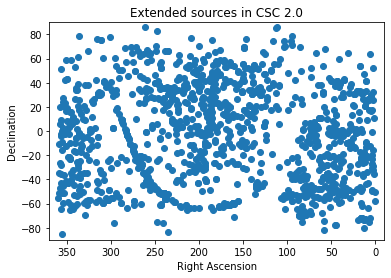

In [69]:
plt.plot(tresults['ra'], tresults['dec'], 'o')
plt.title('Extended sources in CSC 2.0')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.ylim(-90, 90)
plt.xlim(370, -10);

With this we can run a query on the full master-source catalog. In this case I have selected a subset of the master-source properties, and exclude these "extended" objects". Note that you can ask for more columns,
or add in a cone search (or other simple limits and tests), if you want.

In [70]:
qry = """
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_b, m.flux_aper_lolim_b, m.flux_aper_hilim_b
FROM csc2.master_source m
WHERE m.name NOT LIKE '%X'
"""

In [71]:
%time cat = tap.search(qry)

CPU times: user 15.1 s, sys: 334 ms, total: 15.4 s
Wall time: 27.8 s


We should get about 310,000 results, which is fortunately less than the maximum number of rows you can make in a query against this service (as shown by the `maxrec` parameter):

In [72]:
tap.maxrec

1000000

In [73]:
len(cat)

315868

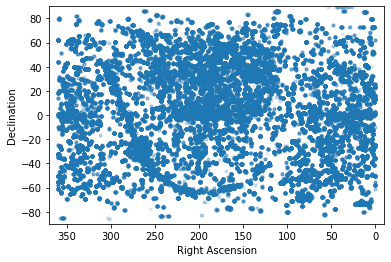

In [74]:
plt.plot(cat['ra'], cat['dec'], '.', alpha=0.1)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.ylim(-90, 90)
plt.xlim(370, -10);

As we have enough points we can use a [`hexbin` plot](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.hexbin.html) to display the flux-significance data:

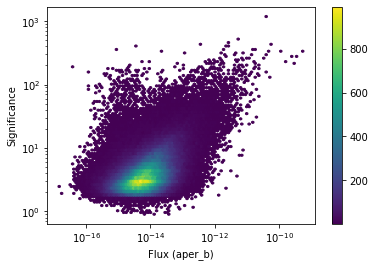

In [75]:
idx = (cat['flux_aper_b'] > 0) & (cat['significance'] > 0)
plt.hexbin(cat['flux_aper_b'][idx], cat['significance'][idx],
           xscale='log', yscale='log', mincnt=1)
plt.colorbar()
plt.xlabel('Flux (aper_b)')
plt.ylabel('Significance');

The output can be written out but, as we include the `name` column, the same work-around as earlier is used:

In [76]:
type(cat)

pyvo.dal.tap.TAPResults

In [77]:
tbl = cat.to_table()
tbl['name'] = [str(n) for n in tbl['name']]

In [78]:
tbl.write('csc2.fits', format='fits', overwrite=True)

---

For users of CIAO, we can use the `ciao_contrib.runtool` module to run the CIAO tool `dmlist` as if it were a Python command, and view the contents of the files we have written out:

In [81]:
#import ciao 
#help(ciao)
import ciao_contrib.runtool as rt


ModuleNotFoundError: No module named 'ciao_contrib'

In [1]:
from ciao_contrib.runtool import dmlist

ModuleNotFoundError: No module named 'ciao_contrib'

First the `ngc1333.fits` file:

In [ ]:
dmlist('ngc1333.fits', 'blocks')

 
--------------------------------------------------------------------------------
Dataset: ngc1333.fits
--------------------------------------------------------------------------------
 
     Block Name                          Type         Dimensions
--------------------------------------------------------------------------------
Block    1: PRIMARY                        Null        
Block    2: HDU2                           Table        24 cols x 11       rows

In [83]:
dmlist('ngc1333.fits', 'cols')

NameError: name 'dmlist' is not defined

and now the `csc2.fits` file:

In [82]:
dmlist('csc2.fits', 'blocks')

NameError: name 'dmlist' is not defined

In [ ]:
dmlist('csc2.fits', 'cols')

 
--------------------------------------------------------------------------------
Columns for Table Block HDU2
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   name                              String[22]                          
   2   ra                   deg          Real8          -Inf:+Inf            
   3   dec                  deg          Real8          -Inf:+Inf            
   4   conf_flag                         Int4           -                    
   5   significance                      Real8          -Inf:+Inf            
   6   extent_flag                       Int4           -                    
   7   sat_src_flag                      Int4           -                    
   8   flux_aper_b          erg/s/cm^2   Real8          -Inf:+Inf            
   9   flux_aper_lolim_b    erg/s/cm^2   Real8          -Inf:+Inf            
  10   flux_aper_hilim_b    erg/s/cm^2  